# Load Dataset
[Dataset link](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews)

In [1]:
import pandas as pd
df = pd.read_csv("Food_Reviews.csv")
df = df[['Score', 'Text', 'Summary','Time']]
df.dropna(inplace=True)

print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (568427, 4)


,Score,Text,Summary,Time
0,5,I have bought several of the Vitality canned d...,Good Quality Dog Food,1303862400
1,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1346976000
2,4,This is a confection that has been around a fe...,"""Delight"" says it all",1219017600
3,2,If you are looking for the secret ingredient i...,Cough Medicine,1307923200
4,5,Great taffy at a great price. There was a wid...,Great taffy,1350777600


# 1. Data Preprocessing & Cleaning

In [2]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)      # remove HTML
    text = re.sub(r'[^a-zA-Z]', ' ', text) # take only letters
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

df['clean_text'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text Vectorization

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['clean_text'])
y = df['Score']


# 2. Exploratory Text Analysis

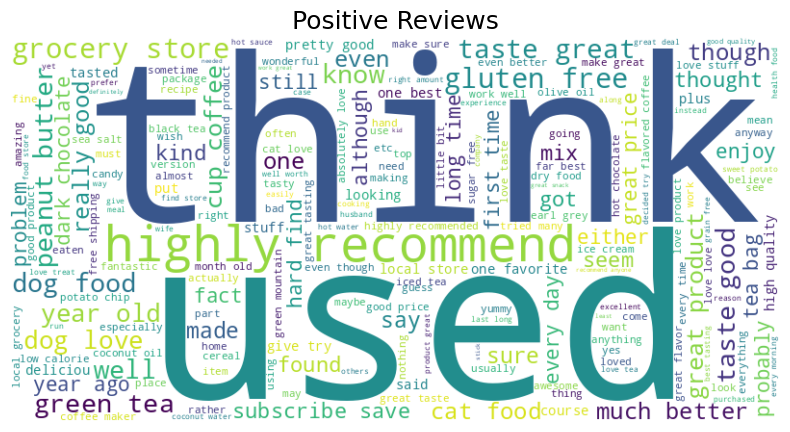

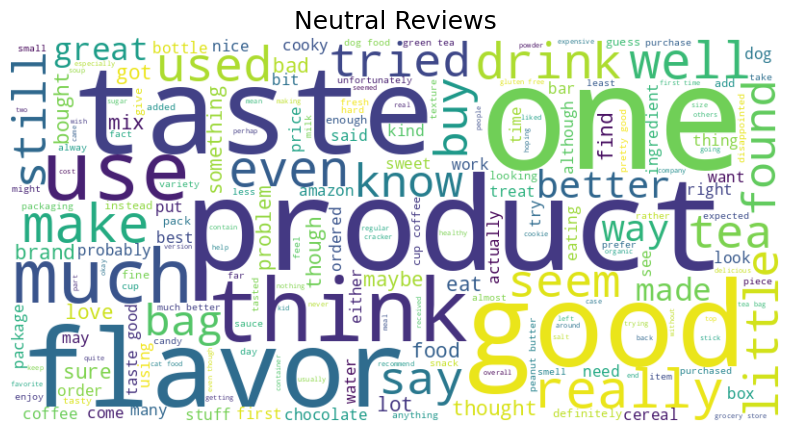

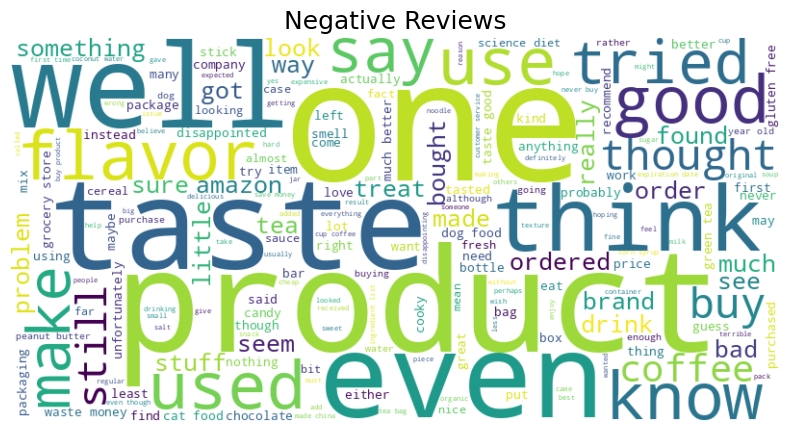

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(data, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()

# wordcloud for different reviews
generate_wordcloud(df[df['Score'] >= 4]['clean_text'], "Positive Reviews")
generate_wordcloud(df[df['Score'] == 3]['clean_text'], "Neutral Reviews")
generate_wordcloud(df[df['Score'] <= 2]['clean_text'], "Negative Reviews")


N-Gram Analysis to find common phrases

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

top_bigrams = get_top_ngrams(df['clean_text'], (2,2), 10)
print("Top Bigrams:", top_bigrams)


Top Bigrams: [('taste like', 26613), ('grocery store', 16828), ('gluten free', 16380), ('dog food', 15251), ('highly recommend', 14551), ('taste good', 14344), ('green tea', 14301), ('peanut butter', 14171), ('taste great', 14078), ('year old', 12280)]


# 3. Sentiment Classification (LogReg, NB, SVM)

In [6]:
import numpy as np

def map_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Score'].apply(map_sentiment)
#sentiment distribution
print(df['sentiment'].value_counts())


sentiment
positive    443777
negative     82012
neutral      42638
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

X = X_tfidf
y = df['sentiment']
# splitting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Log Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


Logistic Regression:
[[11118   653  4631]
 [ 1856  1606  5066]
 [ 1955   877 85924]]
              precision    recall  f1-score   support

    negative       0.74      0.68      0.71     16402
     neutral       0.51      0.19      0.28      8528
    positive       0.90      0.97      0.93     88756

    accuracy                           0.87    113686
   macro avg       0.72      0.61      0.64    113686
weighted avg       0.85      0.87      0.85    113686



NB

In [9]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes:")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes:
[[ 5362    31 11009]
 [  607    88  7833]
 [  544    19 88193]]
              precision    recall  f1-score   support

    negative       0.82      0.33      0.47     16402
     neutral       0.64      0.01      0.02      8528
    positive       0.82      0.99      0.90     88756

    accuracy                           0.82    113686
   macro avg       0.76      0.44      0.46    113686
weighted avg       0.81      0.82      0.77    113686



SVM

In [10]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM:
[[11264   284  4854]
 [ 2050   986  5492]
 [ 2026   407 86323]]
              precision    recall  f1-score   support

    negative       0.73      0.69      0.71     16402
     neutral       0.59      0.12      0.19      8528
    positive       0.89      0.97      0.93     88756

    accuracy                           0.87    113686
   macro avg       0.74      0.59      0.61    113686
weighted avg       0.85      0.87      0.84    113686



Accuracy Comparison of different classifiers

In [11]:
from sklearn.metrics import accuracy_score

print("Accuracy Comparison:")
print("Logistic Regression:", accuracy_score(y_test, y_pred_logreg))
print("Naive Bayes:", accuracy_score(y_test, y_pred_nb))
print("SVM:", accuracy_score(y_test, y_pred_svm))


Accuracy Comparison:
Logistic Regression: 0.8677233784283025
Naive Bayes: 0.8236986084478299
SVM: 0.8670636665904333


# 4. Topic Modeling and Keyword Extraction

Using BERTopic for topic modelling

In [17]:
!pip install bertopic sentence-transformers umap-learn hdbscan --quiet
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/hdbscan/plots.py:448: DeprecationWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.11/dist-packages/hdbscan/robust_single_linkage_.py:154: DeprecationWarning: invalid escape sequence '\{'
  """Perform robust single linkage clustering from a vector array
/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos
/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg

In [18]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
sample_texts = df['clean_text'].dropna().sample(5000,random_state=42).tolist()

#training the model
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)
topics, probs = topic_model.fit_transform(sample_texts)

#top 10 topics
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

print("\nTopic 0 Keywords:")
print(topic_model.get_topic(0))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-07-17 08:48:36,116 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2025-07-17 08:48:43,285 - BERTopic - Embedding - Completed ✓
2025-07-17 08:48:43,286 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-17 08:49:16,906 - BERTopic - Dimensionality - Completed ✓
2025-07-17 08:49:16,908 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-17 08:49:17,094 - BERTopic - Cluster - Completed ✓
2025-07-17 08:49:17,103 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-17 08:49:17,294 - BERTopic - Representation - Completed ✓


   Topic  Count                           Name  \
0     -1   1580      -1_taste_like_flavor_good   
1      0    695           0_dog_cat_food_treat   
2      1    634         1_coffee_cup_roast_pod   
3      2    180  2_price_shipping_amazon_order   
4      3    146         3_tea_leaf_green_stash   
5      4     99        4_sauce_hot_heat_pepper   
6      5     88     5_chocolate_cocoa_hot_milk   
7      6     82       6_bar_snack_gram_healthy   
8      7     71  7_candy_gift_christmas_haribo   
9      8     69   8_gluten_free_pancake_baking   

                                      Representation  \
0  [taste, like, flavor, good, product, great, on...   
1  [dog, cat, food, treat, love, vet, eat, get, f...   
2  [coffee, cup, roast, pod, bold, strong, bean, ...   
3  [price, shipping, amazon, order, product, ship...   
4  [tea, leaf, green, stash, jasmine, bag, flavor...   
5  [sauce, hot, heat, pepper, tomato, dish, spicy...   
6  [chocolate, cocoa, hot, milk, powder, dark, ta...   
7

In [19]:
# Interactive topic visualization
topic_model.visualize_topics()


In [20]:
topic_model.visualize_barchart(top_n_topics=10)
topic_model.visualize_heatmap()


In [21]:
topic_sentiment_df = pd.DataFrame({
    'text': sample_texts,
    'topic': topics,
    'probability': probs
})
topic_sentiment_df['sentiment'] = df.loc[topic_sentiment_df.index, 'sentiment'].values

# Counting sentiment per topic
topic_sentiment_count = topic_sentiment_df.groupby(['topic', 'sentiment']).size().unstack().fillna(0)
print(topic_sentiment_count.head())


sentiment  negative  neutral  positive
topic                                 
-1            227.0    126.0    1227.0
 0            100.0     69.0     526.0
 1             98.0     48.0     488.0
 2             29.0     20.0     131.0
 3             19.0     12.0     115.0


# 5. Trend Analysis

In [22]:
#UNIX time to date conversion
df['date'] = pd.to_datetime(df['Time'], unit='s')
df['year_month'] = df['date'].dt.to_period('M')
print(df[['Time', 'date', 'year_month']].head())


         Time       date year_month
0  1303862400 2011-04-27    2011-04
1  1346976000 2012-09-07    2012-09
2  1219017600 2008-08-18    2008-08
3  1307923200 2011-06-13    2011-06
4  1350777600 2012-10-21    2012-10


Sentiment over time

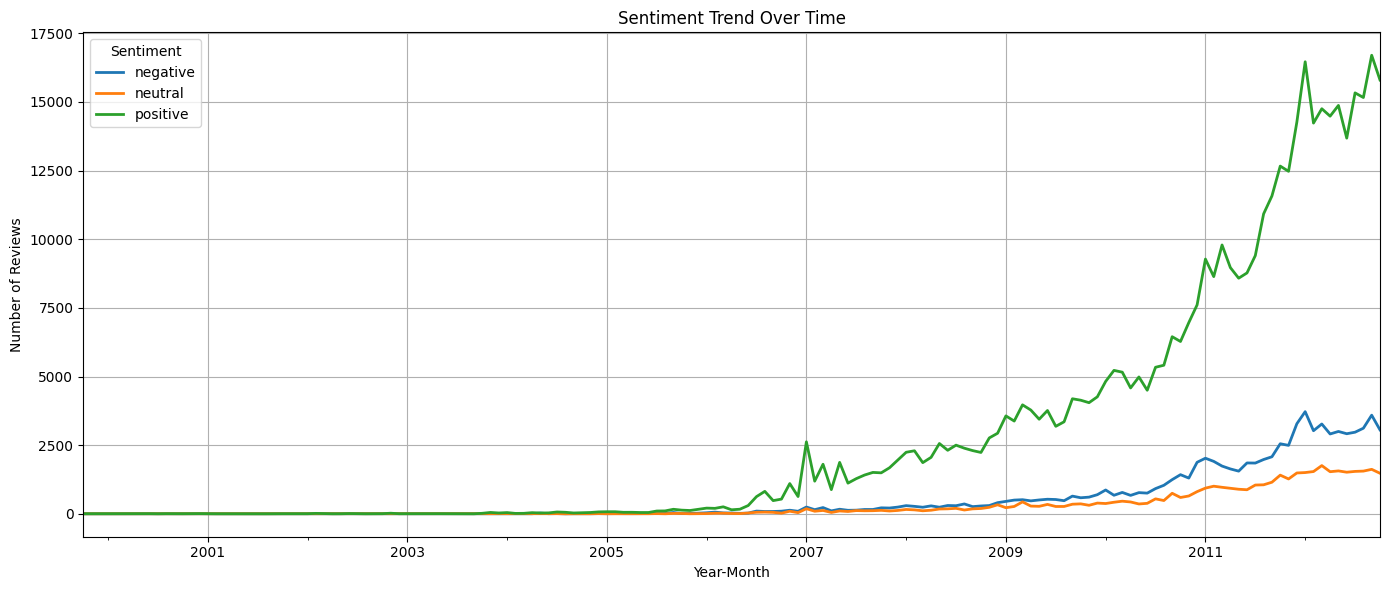

In [23]:
import matplotlib.pyplot as plt


sentiment_trend = df.groupby(['year_month', 'sentiment']).size().unstack().fillna(0)


sentiment_trend.plot(figsize=(14,6), linewidth=2)
plt.title('Sentiment Trend Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


Seasonal spike in sentiment

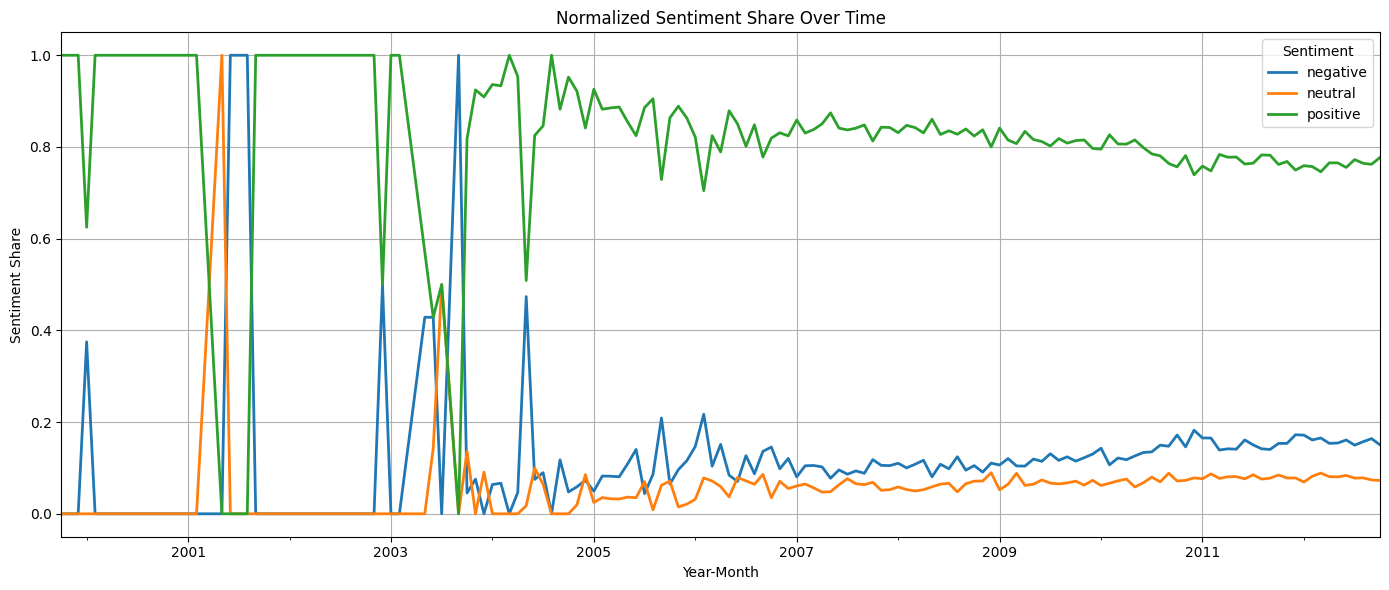

In [24]:
sentiment_share = sentiment_trend.divide(sentiment_trend.sum(axis=1), axis=0)
sentiment_share.plot(figsize=(14,6), linewidth=2)
plt.title('Normalized Sentiment Share Over Time')
plt.ylabel('Sentiment Share')
plt.xlabel('Year-Month')
plt.legend(title="Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
#months with most negative reviews
top_negative = sentiment_trend['negative'].sort_values(ascending=False).head(5)
print("Top 5 negative sentiment spikes:")
print(top_negative)


Top 5 negative sentiment spikes:
year_month
2012-01    3720.0
2012-09    3592.0
2011-12    3281.0
2012-03    3271.0
2012-08    3117.0
Freq: M, Name: negative, dtype: float64


# 6. Named Entity Recognition

In [ ]:
!pip install spacy --quiet
!python -m spacy download en_core_web_sm

In [27]:
import spacy
from collections import Counter
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

# Entities from first 1000 rows
entities = []
for doc in tqdm(df['Text'].iloc[:1000]):
    spacy_doc = nlp(doc)
    for ent in spacy_doc.ents:
        entities.append((ent.text.strip(), ent.label_))

# Most common named entities
entity_df = pd.DataFrame(entities, columns=["Entity", "Label"])
top_entities = entity_df.groupby("Label")["Entity"].apply(lambda x: Counter(x).most_common(5))

print("Top Named Entities per Category:")
print(top_entities)


100%|██████████| 1000/1000 [00:35<00:00, 28.48it/s]

Top Named Entities per Category:
Label
CARDINAL       [(one, 64), (two, 41), (2, 39), (3, 24), (4, 22)]
DATE           [(daily, 10), (Christmas, 9), (the day, 8), (y...
EVENT          [(Firms, 1), (a CostPlus World Market, 1), (th...
FAC            [(the Lapsang Souchong, 1), (Salsa Suprema, 1)...
GPE            [(Felidae, 6), (USA, 6), (New York, 6), (the U...
LANGUAGE                                          [(English, 2)]
LAW            [(the Root Beer Extract I, 1), (the Guinness B...
LOC            [(Earth, 22), (Green Mountain, 5), (Mango, 2),...
MONEY           [(20, 3), (6, 2), (10, 2), (9.99, 2), (4.00, 2)]
NORP           [(Japanese, 10), (Thai, 9), (German, 6), (Spic...
ORDINAL        [(first, 75), (second, 13), (First, 4), (4th, ...
ORG            [(Amazon, 107), (Kettle, 29), (Kettle Brand, 2...
PERCENT          [(100%, 9), (6%, 6), (2%, 6), (8%, 5), (4%, 4)]
PERSON         [(Kettle, 27), (Earl Grey, 11), (Solomon, 10),...
PRODUCT        [(Starbucks, 2), (Edmund, 1), (Kleen

# 7. Actionable Insight Generation





In [28]:
from sklearn.feature_extraction.text import CountVectorizer

def top_keywords(docs, top_n=20):
    vec = CountVectorizer(stop_words='english', max_features=1000)
    bag = vec.fit_transform(docs)
    sum_words = bag.sum(axis=0)
    keywords = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(keywords, key=lambda x: x[1], reverse=True)[:top_n]

positive_reviews = df[df['sentiment'] == 'positive']['clean_text']
negative_reviews = df[df['sentiment'] == 'negative']['clean_text']

print("👍 Top praised keywords:")
print(top_keywords(positive_reviews))

print("\n👎 Most criticized keywords:")
print(top_keywords(negative_reviews))


👍 Top praised keywords:
[('like', 194772), ('good', 161419), ('taste', 154163), ('great', 150389), ('love', 145700), ('flavor', 141909), ('coffee', 133040), ('product', 126775), ('tea', 124042), ('food', 116846), ('make', 87767), ('dog', 81139), ('time', 78583), ('really', 76547), ('amazon', 70472), ('best', 68826), ('use', 68590), ('cup', 68332), ('little', 66241), ('price', 65370)]

👎 Most criticized keywords:
[('like', 45560), ('product', 40333), ('taste', 39996), ('food', 25982), ('flavor', 25253), ('coffee', 23778), ('good', 21878), ('dog', 17993), ('tea', 17834), ('box', 15585), ('bag', 15340), ('buy', 15122), ('amazon', 14829), ('time', 14820), ('really', 14479), ('cup', 13194), ('make', 12113), ('tried', 12043), ('bought', 11241), ('eat', 10743)]


# 8. Reporting and Visualization

Sentiment Distribution

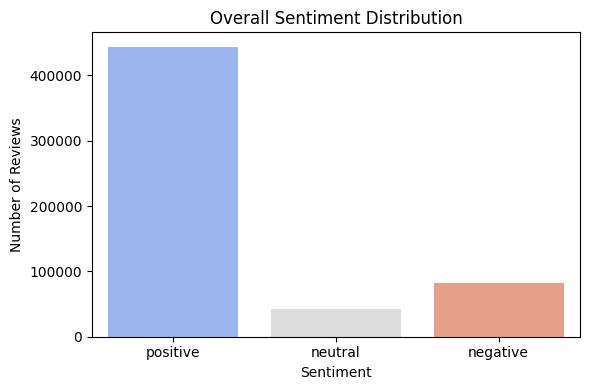

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='coolwarm')
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


Sentiment over Time

In [31]:
import plotly.express as px

trend_df = df.groupby(['year_month', 'sentiment']).size().reset_index(name='count')
trend_df['year_month'] = trend_df['year_month'].astype(str)

fig = px.line(trend_df, x='year_month', y='count', color='sentiment',
              title="Sentiment Over Time", markers=True)
fig.update_layout(xaxis_title='Month', yaxis_title='Review Count', template='plotly_white')
fig.show()


Top keywords

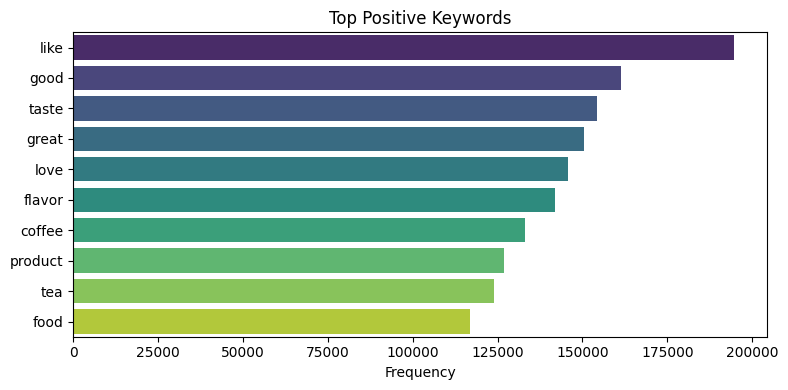

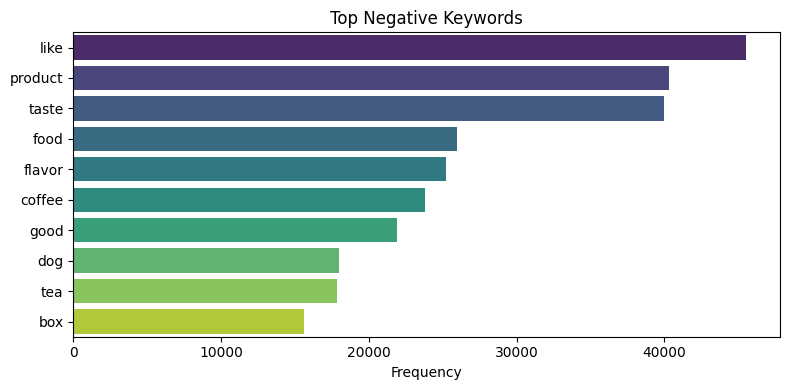

In [32]:
def plot_top_words(word_freq, title):
    words, freqs = zip(*word_freq[:10])
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(freqs), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_words(top_keywords(positive_reviews), "Top Positive Keywords")
plot_top_words(top_keywords(negative_reviews), "Top Negative Keywords")


Review Heat Maps

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)
topic_model.visualize_heatmap()


In [36]:
df.to_csv('refined_reviews.csv', index=False)

In [38]:
topic_model.save("bertopic_model", save_embedding_model=True)


2025-07-17 09:05:51,591 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
